<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Lab Session 3 : Optical flow </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
V. Burdin <span style="color:blue">valerie.burdin@imt-atlantique.fr</span>
<CENTER>
</CENTER>
</div> 

# Authors: Imane Momayiz and Tales Marra

The objectives of this lab session are as follows: 
* understand and implement the *Horn and Schunck*'s optical flow method,
* evaluate this method using dedicated functions,
* compare the obtained results with other optical flow methods,
* perform long-term motion estimation
***

## I - Theory

The starting point for most optical flow estimation methods is to assume that the intensity of a given point remains constant between two consecutive images, whatever the nature of its motion. The following **brightness constancy constraint** arises:

\begin{align*}
\frac{\partial I(x,t)}{\partial t} + u(x). \nabla I(x,t) = 0
\end{align*}

Assuming small displacements and spatio-temporal differentiability of intensity, we observe that temporal changes are equivalent to the scalar product between spatial changes and apparent motion. Motion estimation using intensity conservation as only constraint is an **under-determined** problem. The above equation alone does not allow to estimate the two unknown variables $u(x)=\big(u(x,y),v(x,y)\big)$. This problem, known as the **aperture problem**, can be circumvented by adding **local** or **global constraints**.

Contrary to *Lucas-Kanade*'s optical flow method ([paper](http://www.cs.princeton.edu/courses/archive/spring04/cos429/papers/lucas_kanade.pdf)) which exploits local contraints, the so-called **global approaches** including *Horn Schunck*'s optical flow ([paper](http://people.csail.mit.edu/bkph/AIM/AIM-572.pdf)) introduce a hypothesis of continuity (smoothing) of the deformation field. The regularization leads to the minimization of a functional with a **data term** and a **smoothing term** to model how optical flow varies spatially:

\begin{align*}
min_{\substack{(u,v)}}
\left(
\int_{\Omega}
\left[
\frac{\partial I(x,t)}{\partial t} 
+ u(x).\nabla I(x,t) 
\right]^{2}
+ \lambda \left[(\frac{\partial u}{\partial x})^2+(\frac{\partial u}{\partial y})^2+(\frac{\partial v}{\partial x})^2+(\frac{\partial v}{\partial y})^2 \right]d\Omega
\right)
\end{align*}

**Question 1 -** The minimization of the quadratic *Horn Schunck* **functional** leads to the following **iterative resolution scheme**:

\begin{align*}
\left\{
\begin{array}{l}
u^{k} = \bar{u}^{k-1} - I_{x}(I_{x}\bar{u}^{k-1}+I_{y}\bar{v}^{k-1}+I_{t}).(I_{x}^{2}+I_{y}^{2}+\lambda)^{-1} \\
v^{k} = \bar{v}^{k-1} - I_{y}(I_{x}\bar{u}^{k-1}+I_{y}\bar{v}^{k-1}+I_{t}).(I_{x}^{2}+I_{y}^{2}+\lambda)^{-1} \\
\end{array}
\right.
\end{align*}

Retrieve this result analytically (see appendix).

**Question 2 -** What is the main advantage of global methods such as *Horn Schunck* compared to local methods for the specific case of uniform areas?

**Answer**: Global methods such as HS make the assumption that the flow field varies smoothly in a given neighborhood. This results in a dense flow field and thus in the case of uniform areas in higher spatial resolution and accuracy.

***

## II - Implementation of *Horn and Schunck's* method

The goal of this part is to implement and evaluate the *Horn and Schunck*'s optical flow method ([paper](http://people.csail.mit.edu/bkph/AIM/AIM-572.pdf)). Let us focus on a first image pair, <font color=blue>taxi1/2.png</font>.

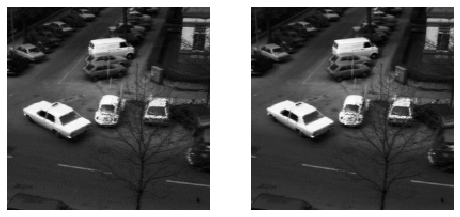

In [14]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

name = 'taxi'
img1 = io.imread('./images/'+name+'1.png',as_gray=True).astype(np.float32)/255.
img2 = io.imread('./images/'+name+'2.png',as_gray=True).astype(np.float32)/255.

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.axis('off')
plt.imshow(img1,cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.imshow(img2,cmap='gray')
plt.show()

**Question 3 -** Implement the function **estimate_derivative()** whose goal is to compute spatial (in x- and y- directions) and temporal derivatives. These derivatives can be obtained by convolving (**scipy.ndimage.filters.convolve()**) the image with provided kernels **kernelX**, **kernelX** and **kernelT**. To validate the implementation, visualize the spatial and temporal derivative maps on the image pair <font color=blue>taxi1/2.png</font> using **plotderiv()**.

In [15]:
from scipy.ndimage.filters import convolve

def estimate_derivatives(img1, img2):
    kernelX = np.array([[-1, -1],[1, 1]])*.25  # kernel for computing d/dx
    kernelY = np.array([[-1, 1],[ -1, 1]])*.25 # kernel for computing d/dy
    kernelT = np.ones((2,2))*.25
    
    fx = convolve((img1),kernelX)
    fy = convolve((img1),kernelY)
    ft = convolve((img1-img2),kernelT)
    return fx, fy, ft

In [16]:
def plotderiv(fx,fy,ft):
    fg,ax = plt.subplots(1,3,figsize=(18,5))
    for f,a,t in zip((fx,fy,ft),ax,('$f_x$','$f_y$','$f_t$')):
        h=a.imshow(f,cmap='bwr')
        a.set_title(t)
        fg.colorbar(h,ax=a)
    plt.show()

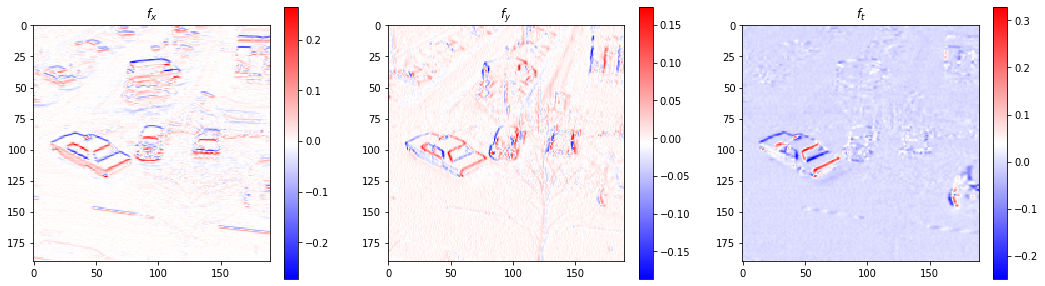

In [17]:
fx, fy, ft = estimate_derivatives(img1, img2)
plotderiv(fx,fy,ft) 

To compute *Horn and Schunck's* optical flow, we need to:
* estimate spatial and temporal derivated (**estimate_derivatives()**),
* compute averaged displacement fields,
* update the displacement field according to the resolution scheme indicated above.

The two last steps are performed iteratively.

**Question 4 -** Make the implementation of the function **flow = horn\_schunck(img1, img2, lambda_, Niter)**. This function will take as input two grayscale images (**img1**, **img2**), the relative weight **lambda_** between the data attachment and the regularization terms as well as the desired number of iterations (**Niter**). As an output, **horn_schunck()** will return a dense field of matches from **img1** to **img2** in the form of an *numpy* array of floating type and size **[nb\_row, nb\_col, 2]** where **nb_row** (resp. **nb_col**) correspond to the number of lines (columns) of image **img1**. To be compatible with the provided visualization functions, **flow[:,:,0]**. (resp. **flow[:,:,1]**) must contain estimates of the **v** (resp. **u**) component.

In [18]:
def horn_schunck(img1, img2, lambda_, Niter):
    
    kernelA = np.array([[1./12,1./6,1./12],[1./6,0,1./6], [1./12,1./6,1./12]], np.float)
    # TO DO
    Ix, Iy, It = estimate_derivatives(img1, img2)
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    n= u.shape[0]
    n1= u.shape[1]
    flow = np.zeros((n,n1,2))
    for it in range(Niter):
        ubar = convolve(u,kernelA)
        vbar = convolve(v,kernelA)
        u = ubar - Ix*(Ix*ubar+Iy*vbar+It)/((Ix)**2+(Iy)**2+lambda_)
        v = vbar - Iy*(Ix*ubar+Iy*vbar+It)/((Ix)**2+(Iy)**2+lambda_)
    flow[:,:,0] = v
    flow[:,:,1] = u
    return flow

**Question 5 -** Apply the **horn_schunck()** function on the pair of images <font color=blue>taxi1/2.png</font> with a low weighting factor **lambda_** of 0.001 and 200 iterations (**Niter**).

In [19]:
lambda_ = 0.001
Niter = 200
flow = horn_schunck(img1, img2, lambda_, Niter)

In [20]:
np.max(flow[:,:,0])

2.235670438949378

**Question 6 -** To evaluate the results qualitatively, you have two functions at your disposal:
**draw_hsv(flow)** which allows to visualize the displacement field using the color wheel and **draw_flow(img, flow, step)** which super-imposes to the image **img1** the optical flow vectors of pixels located on a regular grid (to be defined via the parameter **step**). Write a function **visualization(img1, img2, flow, step)** displaying the two source images (**img1**, **img2**) as well as **draw_hsv(flow)** and **draw_flow(img, flow, step)** outputs and use it for the image pair <font color=blue>taxi1/2.png</font>. Comment on the accuracy.

In [21]:
import cv2

def draw_flow(img, flow, step):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        if abs(x1-x2)>1 or abs(y1-y2)>1:
            cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def draw_hsv(flow):
    flow = -flow
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), np.uint8)    
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 255
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


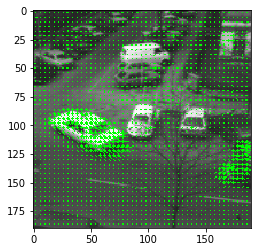

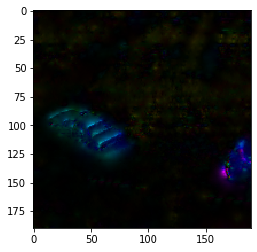

In [22]:
def visualization(img1, img2, flow, step):
    plt.figure(figsize=(18, 4))
    flow_d = draw_flow(img1,2*flow,step)
    rgb = draw_hsv(flow)
    plt.imshow(flow_d)
    plt.figure(figsize=(18, 4))
    plt.imshow(rgb)
    plt.show()
    
step = 4
visualization(img1, img2, flow, step)

**Answer**: It detects well the objects in motion. In the first visualization, we can see a perturbation of the field where objects are moving; and when using the hsv heatmap we can also visualize the same result.

**Question 7 -** Apply the *Horn and Schunck's* method (on <font color=blue>taxi1/2.png</font>) by gradually increasing the $\lambda$ **weighting factor** (from 0.00001 to 0.1) between the data attachment and regularization terms. What do we observe? Which value seems to be optimal?

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


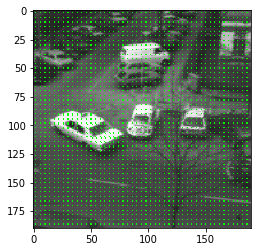

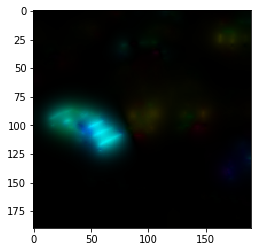

0.1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


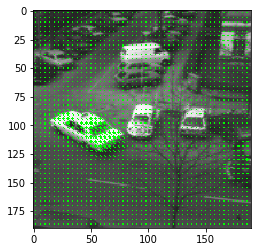

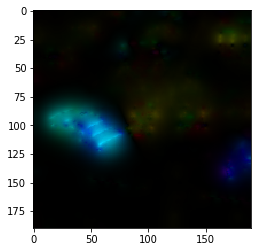

0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


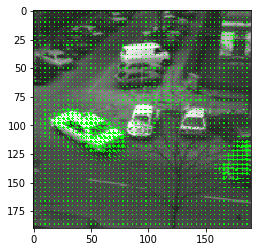

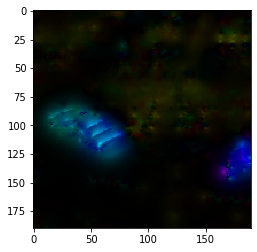

0.001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


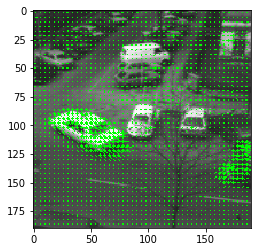

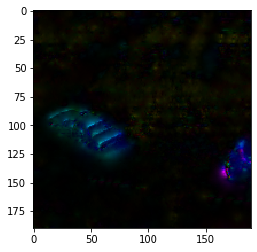

0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


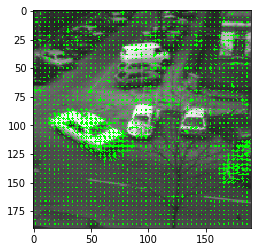

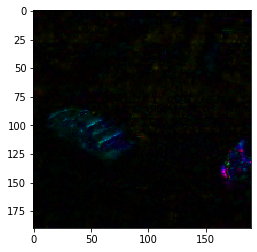

1e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


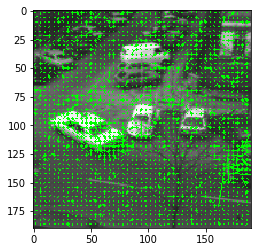

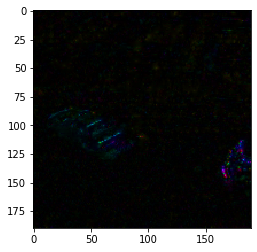

In [23]:
lambdas = [10**-i for i in range(6)]
for lambda_ in lambdas :
    print(lambda_)
    flow = horn_schunck(img1, img2, lambda_, Niter)
    visualization(img1, img2, flow, step)
    

**Anwser**: We can see that increasing the regularization parameter $\lambda$ increases the smoothness of the optical flow. This is related to the impact of the smoothness loss in the total energy objective function.
Lambda=0.01 seems optimal.

** Question 8 -** Which image **pre-processing** can also lead to spatial smoothing of the deformation field? Implement this pre-processing and test the implementation of the *Horn and Schunck*'s method for the following image pairs: <font color=blue>taxi1/2.png</font>, <font color=blue>traffic1/2.png</font>, <font color=blue>table1/2.png</font> and <font color=blue>car1/2.png</font>.

In [24]:
from skimage import filters

taxi


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


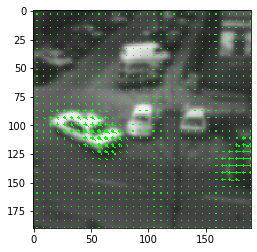

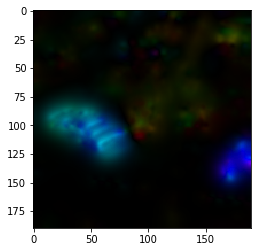

traffic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


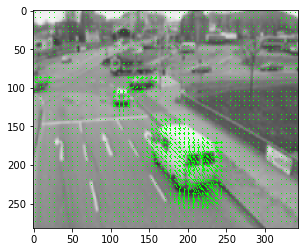

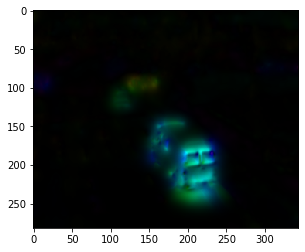

table


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


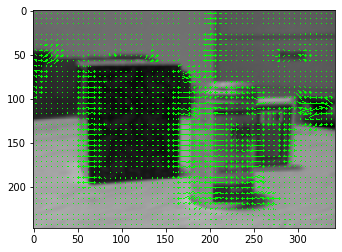

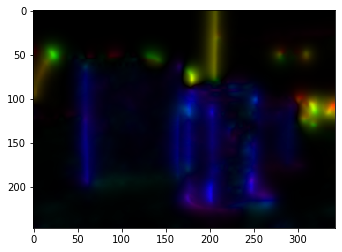

car


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


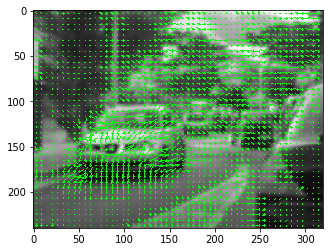

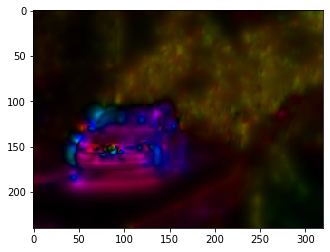

In [25]:
lambda_ = 0.01
sigma = 1.5
step = 6

for name in ['taxi', 'traffic', 'table', 'car']:
    print(name)
    img1 = io.imread('./images/'+name+'1.png').astype(np.float32)/255.
    img2 = io.imread('./images/'+name+'2.png').astype(np.float32)/255.
    img1 = filters.gaussian(img1,sigma=sigma) # pre-processing 
    img2 = filters.gaussian(img2,sigma=sigma) # pre-processing
    flow = horn_schunck(img1, img2, lambda_, Niter)
    visualization(img1, img2, flow, step) 

**Question 9 -** What is the limitation of the *Horn-Schunck*'s method in areas with **motion discontinuities**?

**Answer**: It doesn't capture well the motion in case of discontinuities, because of the smoothness assumption.

**Question 10 -** Study the specific case of **large motion** on the image pair <font color=blue>bike1/2.png</font>. Does the implemented method offer a good estimation for this case? Why?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


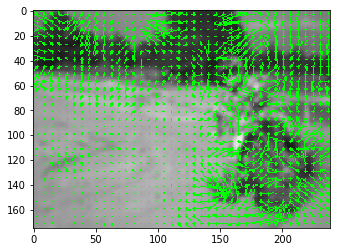

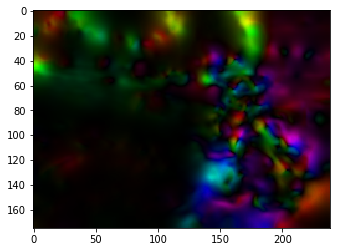

In [12]:
# TO DO
img1 = io.imread('./images/bike1.png').astype(np.float32)/255.
img2 = io.imread('./images/bike2.png').astype(np.float32)/255.
img1 = filters.gaussian(img1,sigma=sigma) # pre-processing 
img2 = filters.gaussian(img2,sigma=sigma) # pre-processing
flow = horn_schunck(img1, img2, lambda_, Niter)
visualization(img1, img2, flow, step)

**Answer**: No it doesn't give a good estimation because of the small displacements assumption.
***

## III - Comparison between optical flow estimators

The objective of this part is to compare *Horn and Schunck*'s optical flow method with other approaches: *Lucas-Kanade* ([paper](http://www.cs.princeton.edu/courses/archive/spring04/cos429/papers/lucas_kanade.pdf)) and *Farneback* ([paper](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf)).

In [26]:
def lucas_kanade(img1, img2, window_size=21, tau=1e-2):
    w = np.int(window_size/2)
    fx, fy, ft = estimate_derivatives(img1, img2)
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    for i in range(w, img1.shape[0]-w):
        for j in range(w, img1.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1))
            A = np.vstack((Ix, Iy)).T
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b)
                u[i,j]=nu[0]
                v[i,j]=nu[1]
    flow = np.zeros((u.shape[0],u.shape[1],2))
    flow[:,:,0], flow[:,:,1]  = -v, -u 
    return flow

In [27]:
def farneback(img1, img2):
    flow = np.zeros((img1.shape[0],img1.shape[1],2))
    img1 = (img1*255.).astype(np.uint8)
    img2 = (img2*255.).astype(np.uint8)
    return cv2.calcOpticalFlowFarneback(img1, img2, flow, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

**Question 11 -** Exploit image pairs <font color=blue>taxi1/2.png</font>, <font color=blue>traffic1/2.png</font>, <font color=blue>table1/2.png</font>, <font color=blue>car1/2.png</font> and <font color=blue>bike1/2.png</font> to compare results obtained by *Horn and Schunck*'s estimator with those from *Lucas-Kanade* and *Farneback* using **draw_flow()** and **draw_hsv()** routines.

taxi


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


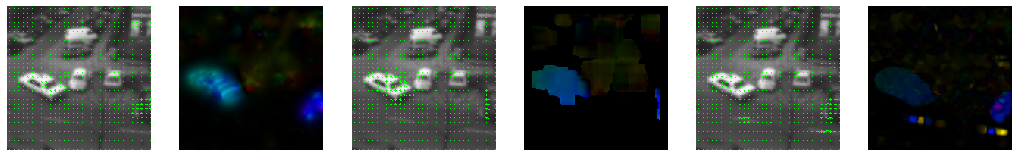

traffic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


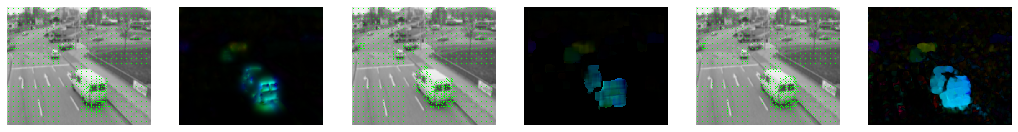

table


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


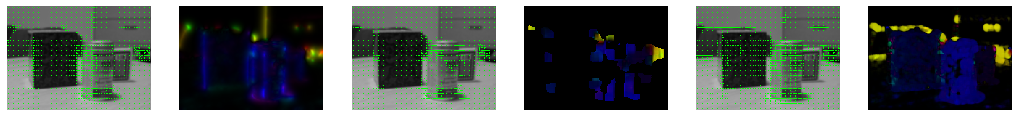

car


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


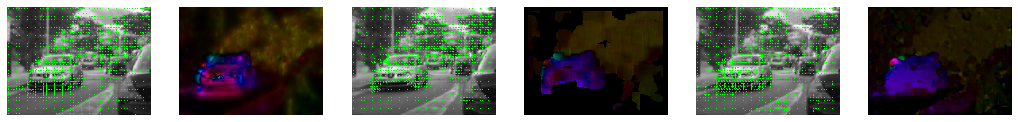

bike


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


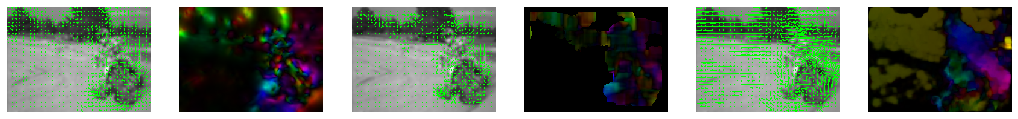

In [28]:
for name in ['taxi', 'traffic', 'table', 'car', 'bike']:
    print(name)
    img1 = io.imread('./images/'+name+'1.png').astype(np.float32)/255.
    img2 = io.imread('./images/'+name+'2.png').astype(np.float32)/255.
    img1 = filters.gaussian(img1,sigma=sigma) # pre-processing
    img2 = filters.gaussian(img2,sigma=sigma) # pre-processing
    flow_HS = horn_schunck(img1, img2, lambda_, Niter)
    flow_LK = lucas_kanade(img1, img2, window_size=21, tau=1e-2)
    flow_Fa = farneback(img1, img2)
    plt.figure(figsize=(18, 4))
    plt.subplot(161)
    plt.axis('off')
    plt.imshow(draw_flow(img1, flow_HS, step))
    plt.subplot(162)
    plt.axis('off')
    plt.imshow(draw_hsv(flow_HS))
    plt.subplot(163)
    plt.axis('off')
    plt.imshow(draw_flow(img1, flow_LK, step))
    plt.subplot(164)
    plt.axis('off')
    plt.imshow(draw_hsv(flow_LK))
    plt.subplot(165)
    plt.axis('off')
    plt.imshow(draw_flow(img1, flow_Fa, step))
    plt.subplot(166)
    plt.axis('off')
    plt.imshow(draw_hsv(flow_Fa))
    plt.show()

**Question 12 -** Implement a **warping** function **warp(flowFW,img2)** allowing, through *retro-propagation*, to reconstruct the image **img1** with the intensities of the pixels of the image **img2**.

In [29]:
def warp(flowFW,img2): 
    warp = np.zeros((img2.shape[0],img2.shape[1])) # assumes that img1 and img2 have the same dimensions
    pos = np.where(warp == 0)
    for px in range(len(pos[0])): # fill warp with greyscale values retro-propagated from img2
        x = pos[0][px]
        y = pos[1][px]
        u,v = flowFW[:,:,1],flowFW[:,:,0]
        if int(x+u[x,y])< img2.shape[0] and int(y+v[x,y])< img2.shape[1]:
            warp[x,y] = img2[int(x+u[x,y]),int(y+v[x,y])]
        elif int(x+u[x,y])>= img2.shape[0]:
            warp[x,y] = img2[-1, int(y+v[x,y])]
        elif int(y+v[x,y])>= img2.shape[1]:
            warp[x,y] = img2[int(x+u[x,y]), -1]
    return warp

**Question 13 -** Compare the reconstructed images obtained through the optical flow fields estimated by *Horn Schunck*, *Lucas Kanade* and *Farneback* estimators. In particular, visualize absolute difference images between *img1* and reconstructed images. Compute the *Peak Signal to Noise Ratio* (PSNR) between reconstructed images and source images by mean of the **skimage.measure.compare_psnr()** routine. Compare the scores obtained on several pairs of images (<font color=blue>taxi1/2.png</font>, <font color=blue>traffic1/2.png</font>, <font color=blue>table1/2.png</font>, <font color=blue>car1/2.png</font>, <font color=blue>bike1/2.png</font>). Which one seems to be the best optical flow estimator?

taxi


/homes/i18momay/.local/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


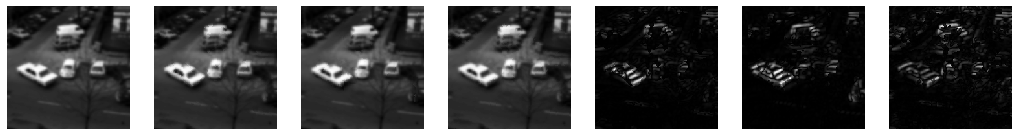

traffic


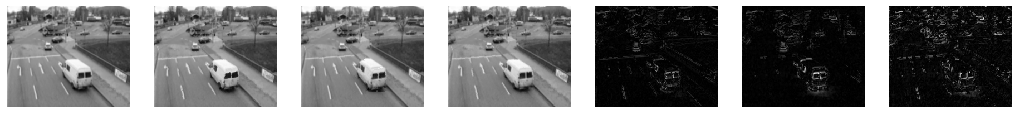

table


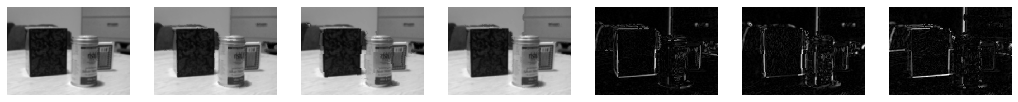

car


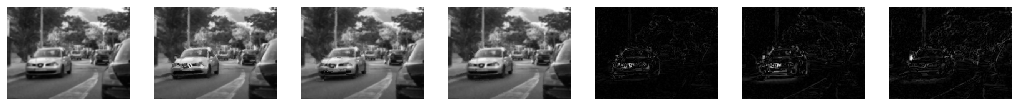

bike


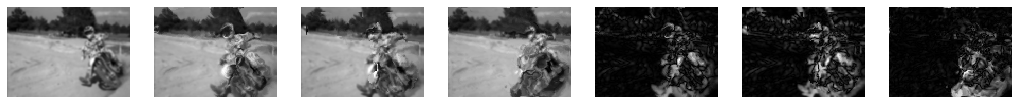

In [30]:
from skimage.measure import compare_psnr

psnrs_HS, psnrs_LK, psnrs_Fa = [], [], []
for name in ['taxi', 'traffic', 'table', 'car', 'bike']:
    print(name)
    img1 = io.imread('./images/'+name+'1.png').astype(np.float32)/255.
    img2 = io.imread('./images/'+name+'2.png').astype(np.float32)/255.
    img1 = filters.gaussian(img1,sigma=sigma) # pre-processing
    img2 = filters.gaussian(img2,sigma=sigma) # pre-processing
    flow_HS = horn_schunck(img1, img2, lambda_, Niter)
    flow_LK = lucas_kanade(img1, img2, window_size=21, tau=1e-2)
    flow_Fa = farneback(img1, img2)
    im1_warp_HS = warp(flow_HS,img2) 
    im1_warp_LK = warp(flow_LK,img2) 
    im1_warp_Fa = warp(flow_Fa,img2) 
    psnrs_HS.append(compare_psnr(img1,im1_warp_HS)) 
    psnrs_LK.append(compare_psnr(img1,im1_warp_LK)) 
    psnrs_Fa.append(compare_psnr(img1,im1_warp_Fa)) 
    plt.figure(figsize=(18, 4))
    plt.subplot(171)
    plt.axis('off')
    plt.imshow(img1,cmap='gray')
    plt.subplot(172)
    plt.axis('off')
    plt.imshow(im1_warp_HS,cmap='gray')
    plt.subplot(173)
    plt.axis('off')
    plt.imshow(im1_warp_LK,cmap='gray')
    plt.subplot(174)
    plt.axis('off')
    plt.imshow(im1_warp_Fa,cmap='gray')
    plt.subplot(175)
    plt.axis('off')
    plt.imshow(abs(img1-im1_warp_HS),cmap='gray') # absolute difference images 
    plt.subplot(176)
    plt.axis('off')
    plt.imshow(abs(img1-im1_warp_LK),cmap='gray') # absolute difference images 
    plt.subplot(177)
    plt.axis('off')
    plt.imshow(abs(img1-im1_warp_Fa),cmap='gray')  # absolute difference images 
    plt.show()
    


In [31]:
print(psnrs_HS)
print(psnrs_LK)
print(psnrs_Fa)
print('HS mean psnrs:' , np.mean(psnrs_HS))  # compute and display averaged PSNR for each estimator
print('LK mean psnrs:' , np.mean(psnrs_LK)) 
print('Fa mean psnrs:' , np.mean(psnrs_Fa)) 

[32.04102212973467, 33.75605696406924, 33.292731718444216, 29.885278257502392, 19.33849755764696]
[31.204684141015253, 33.43753614896238, 32.407645337158016, 28.72144987384884, 18.53753853469035]
[34.58446491085064, 35.79039231543995, 35.961683669584914, 31.4989633844554, 21.814079749980827]
HS mean psnrs: 29.662717325479502
LK mean psnrs: 28.861770807134967
Fa mean psnrs: 31.92991680606235


**Answer:** The best estimator is Farneback with the highest psnr.
***

## IV - Long-term motion estimation

Although robust between consecutive images, optical flow estimators are less efficient between distant images, especially in the following complex situations: variations in illumination, temporary occlusions, zooms, non-rigid distortions or transparency.  However, some dynamic scene analysis applications (visual object tracking, video indexing, action description...) require a dense mapping between distant (non-consecutive) images. 

Let us consider a sequence of N+1 RGB images *In* (with n between 0 and N) where *I0* is a so-called **reference image**. In this context, our objective is to estimate long term motion vectors between the reference image *I0* and each image *In* with $n \neq 0$. In particular, two cases can be considered: 

* **from-the-reference**: estimating long-term displacement field from *I0* to *In*

<div id="image">
<img src="./illustrations/from-the-ref.png" WIDTH=400 HEIGHT=320 title="from-the-reference">
</div>
<div id="subject">
<CENTER>
</br>

* **to-the-reference**: estimation of long-term displacement field from *In* to *I0*

<div id="image">
<img src="./illustrations/to-the-ref.png" WIDTH=400 HEIGHT=320 title="to-the-reference">
</div>
<div id="subject">
<CENTER>
</br>

We focus in this lab session on the **to-the-reference** strategy. To deal with the problem of dense mapping between pairs of images {*In*,*I0*} with n>0, we will exploit an optical flow estimator (*Horn Schunck*, *Lucas-Kanade*, *Farneback* or all 3!) and implement two types of **temporal integration** of optical flow fields : 

* **direct integration**: estimation of optical flow for each pair {*In*,*I0*} independently,
* **sequential integration**: consists in concatenating optical flow vectors computed between consecutive images from *In* to *I0*.

Both integration techniques will be implemented in the context of **object visual tracking** in video sequences. The targeted application consists in estimating for the whole sequence the exact location of a manually defined region of interest in the reference image *I0*. A video sequence containing 20 images is provided with associated groundtruth segmentations: <font color=blue>*swan*</font>.

### Direct integration

In [9]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2])
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask.astype(np.uint8)

In [10]:
def DICE_assessment(groundtruth, estimated):
    A = groundtruth > 0
    B = estimated > 0              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE

**Question 14 -** Implement the **direct integration** of optical flow fields estimated with *Horn Schunck*, *Lucas Kanade* and *Farneback* methods for each pair of images {*In*,*I0*} from the <font color=blue>*swan*</font> sequence. Do not forget to use **skimage.color.rgb2gray()** to process grayscale images. Exploit the **propagate_mask(flow, img_current, mask_begin)** function provided above to propagate the segmentation mask (**mask_begin**) defined in the reference image *I0* to the *In* image (**img_current**) through the estimated displacement field **flow**. The routine **mark_boundaries()** from *skimage.segmentation* will be used to overlay both propagated and groundtruth masks on source images. Additionally to these visualizations, the quality of the propagated segmentation masks will be evaluated for each image using the **Dice score** implemented in **DICE_assessment(groundtruth, estimated)** and comparing both groundtruth (**groundtruth**) and estimated (**estimated**) masks. The Dice scores obtained for each optical flow estimator will be respectively stored in **dir_dices_HS**, **dir_dices_LK** and **dir_dices_Fa** lists.

2


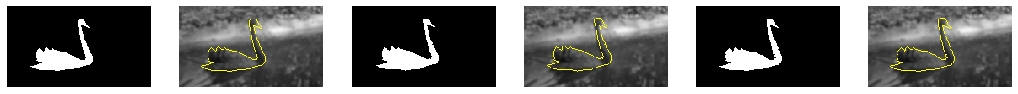

3


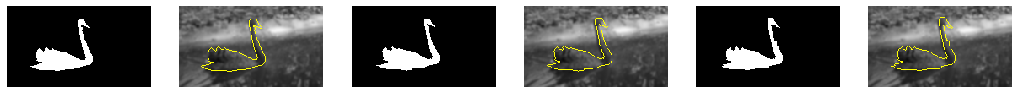

4


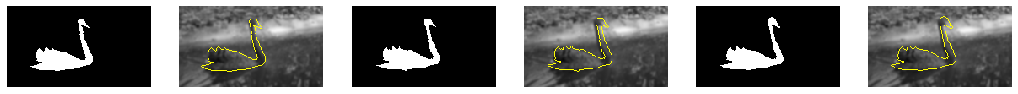

5


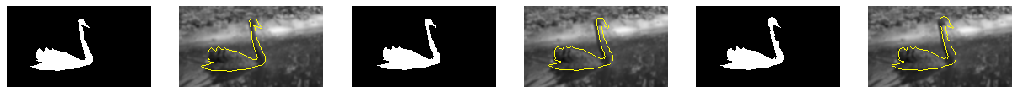

6


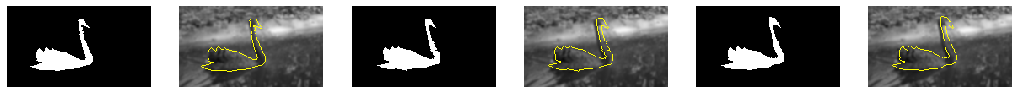

7


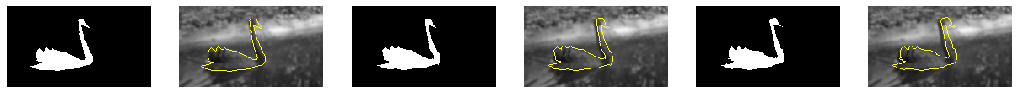

8


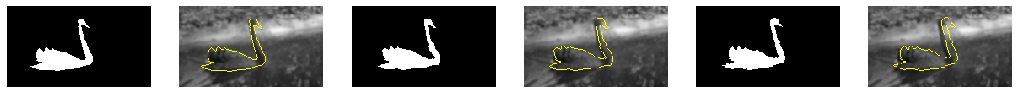

9


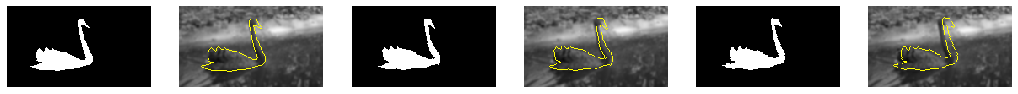

10


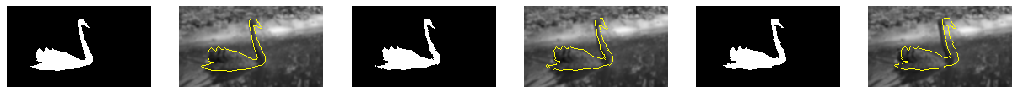

11


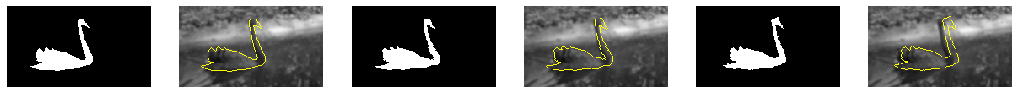

12


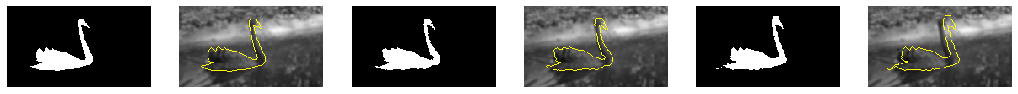

13


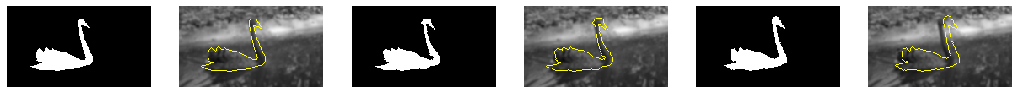

14


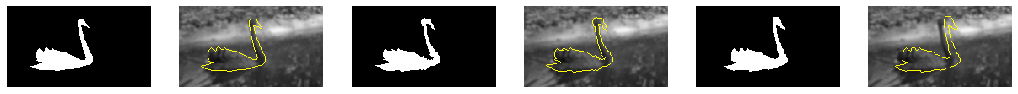

15


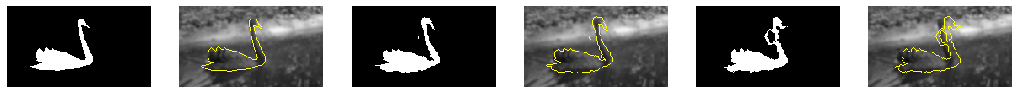

16


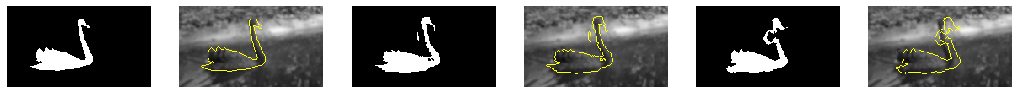

17


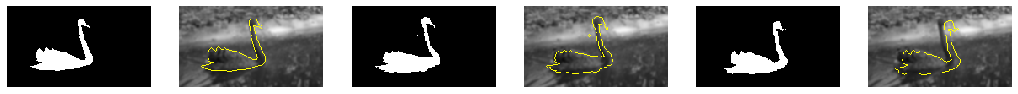

18


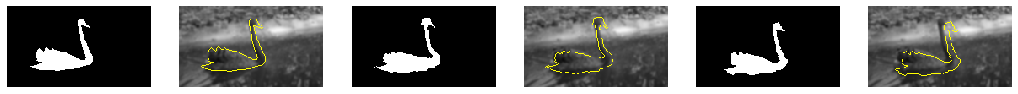

19


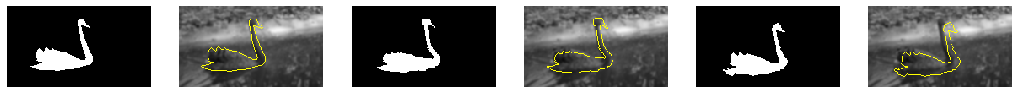

20


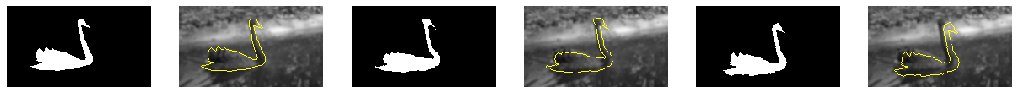

In [39]:
from skimage.color import rgb2gray
from skimage.segmentation import mark_boundaries

im_begin = 1
im_end = 20
sigma = 1
lambda_ = 0.1
Niter = 10
name = 'swan'
img_begin = io.imread('./sequence/'+name+'-%0*d.bmp'%(2,im_begin)).astype(np.float32)/255.
mask_begin = io.imread('./sequence/'+name+'-%0*d.png'%(2,im_begin))
img_begin = rgb2gray(img_begin)
img_begin = filters.gaussian(img_begin,sigma=sigma) # pre-processing
dir_dices_HS, dir_dices_LK, dir_dices_FA = [], [], []
    
for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./sequence/'+name+'-%0*d.bmp'%(2,im)).astype(np.float32)/255.
    mask_current = io.imread('./sequence/'+name+'-%0*d.png'%(2,im))
    img_current = rgb2gray(img_current)
    img_current = filters.gaussian(img_current,sigma=sigma) # pre-processing
    flow_HS = horn_schunck(img_current,img_begin, lambda_, Niter)
    propagation_HS = propagate_mask(flow_HS, img_current, mask_begin) 
    boundaries_HS = mark_boundaries(img_begin,propagation_HS) 
    dir_dices_HS.append(DICE_assessment(mask_current,propagation_HS)) 
    
    flow_LK = lucas_kanade(img_current, img_begin, window_size=21, tau=1e-2)
    propagation_LK = propagate_mask(flow_LK, img_current, mask_begin) 
    boundaries_LK = mark_boundaries(img_begin,propagation_LK) 
    dir_dices_LK.append(DICE_assessment(mask_current,propagation_LK))
        
    flow_FA = farneback(img_current,img_begin) 
    propagation_FA = propagate_mask(flow_FA, img_current, mask_begin) 
    boundaries_FA = mark_boundaries(img_begin,propagation_FA) 
    dir_dices_FA.append(DICE_assessment(mask_current,propagation_FA))
        
    plt.figure(figsize=(18, 4))
    plt.subplot(161)
    plt.axis('off')
    plt.imshow(propagation_HS,cmap='gray')
    plt.subplot(162)
    plt.axis('off')
    plt.imshow(boundaries_HS)
    plt.subplot(163)
    plt.axis('off')
    plt.imshow(propagation_LK,cmap='gray')
    plt.subplot(164)
    plt.axis('off')
    plt.imshow(boundaries_LK)
    plt.subplot(165)
    plt.axis('off')
    plt.imshow(propagation_FA,cmap='gray')
    plt.subplot(166)
    plt.axis('off')
    plt.imshow(boundaries_FA)
    plt.show()

### Sequential integration

Towards an optimal implementation of the sequential integration, we focus on the recursive scheme displayed below for the computation of the long-term displacement vector $d_{n,0}(x_n)$ linking the pixel *xn* in *In* to a sub-pixel position *x0* in *I0*.

\begin{align*}
d_{n,0}(x_n) = x_n - \bar{x}_0 = x_n - \big[u_{n, n-1}(x_{n}) + d_{n-1,0}\big(x_n+u_{n, n-1}(x_{n})\big)\big]   
\end{align*}

We notice here the difference between the estimated optical flow vectors between consecutive images (noted *u*) and the long-term displacement vectors (noted *d*). The concatenation of the optical flow field $u_{n,n-1}$ (**unary_flow**) and the long-term displacement field (**to_ref_flow**) estimated for image pair {*In-1*,*I0*} can be performed using the **concatenation(unary_flow, to_ref_flow)** function provided below.

In [40]:
from scipy.interpolate import interp2d

def concatenation(unary_flow, to_ref_flow):
    flow = np.zeros((unary_flow.shape[0],unary_flow.shape[1],2), dtype=np.float)
    x0 = np.arange(0, unary_flow.shape[0])
    y0 = np.arange(0, unary_flow.shape[1])
    xx, yy = np.meshgrid(x0, y0)
    z = to_ref_flow[xx,yy,1]
    fx = interp2d(x0,y0,z,kind='cubic')
    z = to_ref_flow[xx,yy,0]
    fy = interp2d(x0,y0,z,kind='cubic')
    for x in range(unary_flow.shape[0]):
        for y in range(unary_flow.shape[1]):
            flow_x = fx(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow_y = fy(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow[x,y,1] = unary_flow[x,y,1] + flow_x
            flow[x,y,0] = unary_flow[x,y,0] + flow_y
    return flow

** Question 15 -** Using the resursive scheme and based on **concatenation()**, implement the **sequential integration** using *Horn Schunck*, *Lucas Kanade* and *Farneback* methods for each pair of images {*In*,*I0*} from the <font color=blue>*swan*</font> sequence. As previously, do not forget to use **skimage.color.rgb2gray()** to process grayscale images. Exploit the **propagate_mask(flow, img_current, mask_begin)** function as well as the  **mark_boundaries()** routine to provide visualizations. The quality of the propagated segmentation masks will be evaluated for each image using the **Dice score** implemented in **DICE_assessment(groundtruth, estimated)**. The Dice scores obtained for each optical flow estimator will be respectively stored in **seq_dices_HS**, **seq_dices_LK** and **seq_dices_Fa** lists.

2


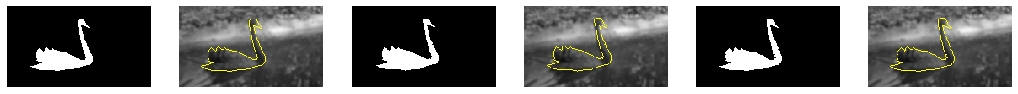

3


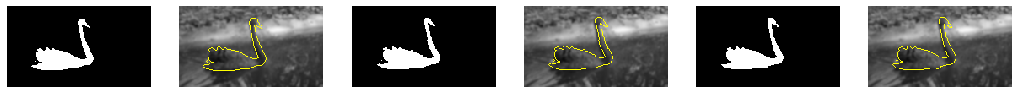

4


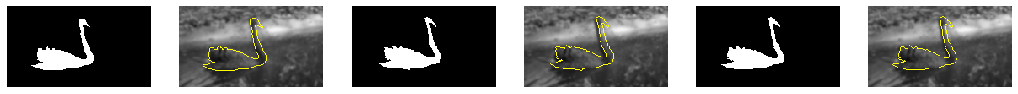

5


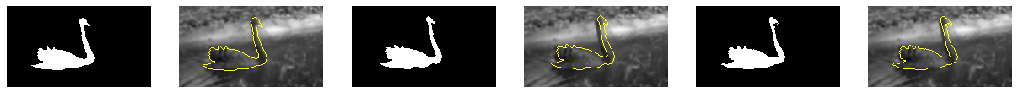

6


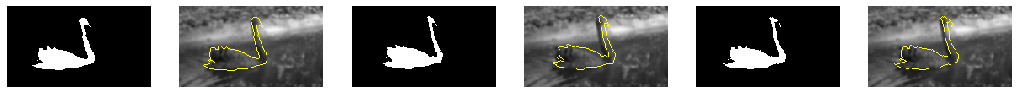

7


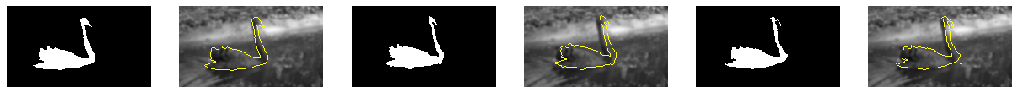

8


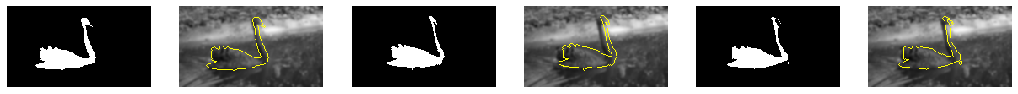

9


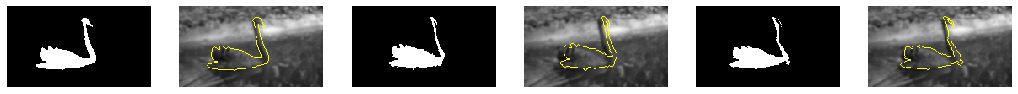

10


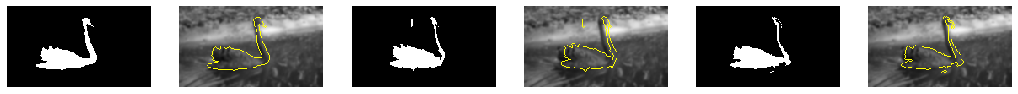

11


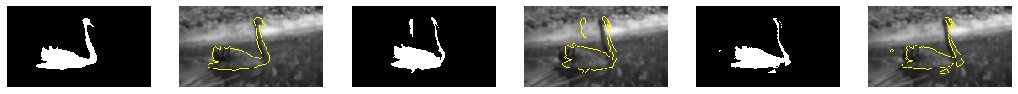

12


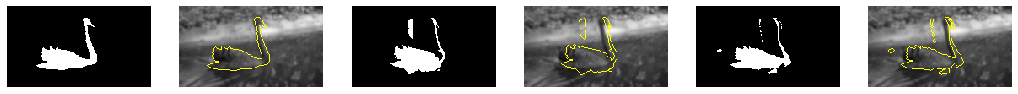

13


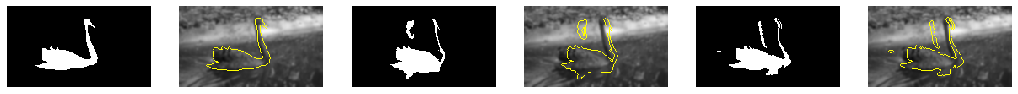

14


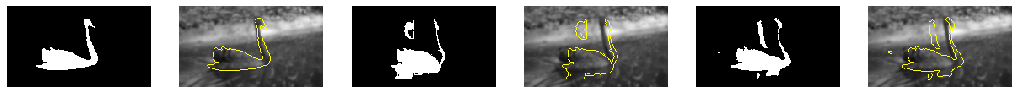

15


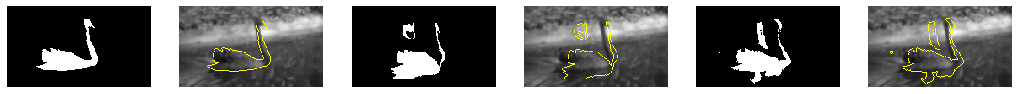

16


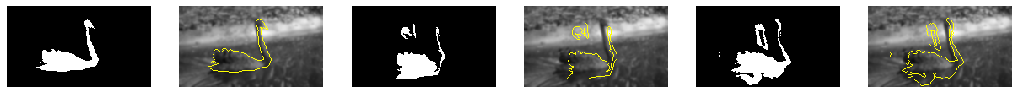

17


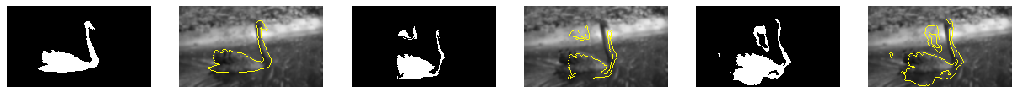

18


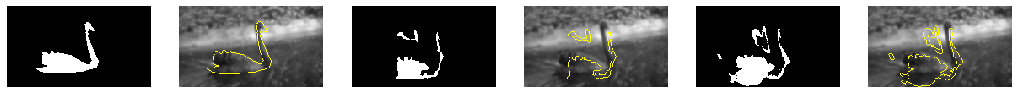

19


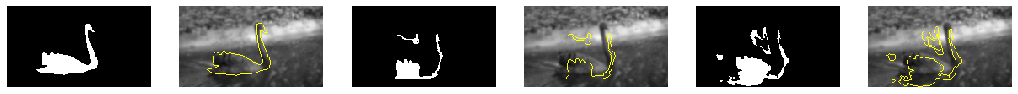

20


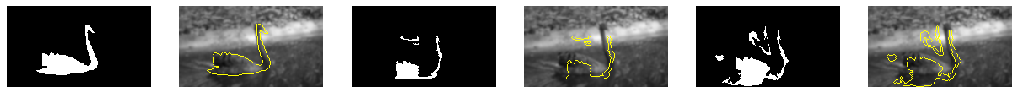

In [43]:
img_begin = io.imread('./sequence/'+name+'-%0*d.bmp'%(2,im_begin)).astype(np.float32)/255.
mask_begin = io.imread('./sequence/'+name+'-%0*d.png'%(2,im_begin))
img_begin = rgb2gray(img_begin)
img_begin = filters.gaussian(img_begin,sigma=sigma) # pre-processing

flow_FA = 0
flow_HS = 0 
flow_LK = 0
seq_dices_HS, seq_dices_LK, seq_dices_FA = [], [], []

for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./sequence/'+name+'-%0*d.bmp'%(2,im)).astype(np.float32)/255.
    mask_current = io.imread('./sequence/'+name+'-%0*d.png'%(2,im))
    img_current = rgb2gray(img_current)
    img_current = filters.gaussian(img_current,sigma=sigma) # pre-processing
    
    img_begin = io.imread('./sequence/'+name+'-%0*d.bmp'%(2,im-1)).astype(np.float32)/255.
    mask_begin = io.imread('./sequence/'+name+'-%0*d.png'%(2,im-1))
    img_begin = rgb2gray(img_begin)
    img_begin = filters.gaussian(img_begin,sigma=sigma) # pre-processing
    # ==== TO DO
    
    
    flow_HS += horn_schunck(img_current,img_begin, lambda_, Niter)
    propagation_HS = propagate_mask(flow_HS, img_current, mask_begin) 
    boundaries_HS = mark_boundaries(img_begin,propagation_HS) 
    seq_dices_HS.append(DICE_assessment(mask_current,propagation_HS)) 
    
    flow_LK += lucas_kanade(img_current, img_begin, window_size=21, tau=1e-2)
    propagation_LK = propagate_mask(flow_LK, img_current, mask_begin) 
    boundaries_LK = mark_boundaries(img_begin,propagation_LK) 
    seq_dices_LK.append(DICE_assessment(mask_current,propagation_LK))
        
    flow_FA += farneback(img_current,img_begin) 
    propagation_FA = propagate_mask(flow_FA, img_current, mask_begin) 
    boundaries_FA = mark_boundaries(img_begin,propagation_FA) 
    seq_dices_FA.append(DICE_assessment(mask_current,propagation_FA))
    
    # ==== 
     
    
    plt.figure(figsize=(18, 4))
    plt.subplot(161)
    plt.axis('off')
    plt.imshow(propagation_HS,cmap='gray')
    plt.subplot(162)
    plt.axis('off')
    plt.imshow(boundaries_HS)
    plt.subplot(163)
    plt.axis('off')
    plt.imshow(propagation_LK,cmap='gray')
    plt.subplot(164)
    plt.axis('off')
    plt.imshow(boundaries_LK)
    plt.subplot(165)
    plt.axis('off')
    plt.imshow(propagation_FA,cmap='gray')
    plt.subplot(166)
    plt.axis('off')
    plt.imshow(boundaries_FA)
    plt.show()

**Question 16 -** Use the following code to display how evolves the accuracy of mask propagation (through Dice scores) along the sequence for each couple optical flow/integration scheme (6 combinations in total). Which integration is the most efficient? What are the advantages/drawbacks of each? Which optical flow estimator gives the best results?

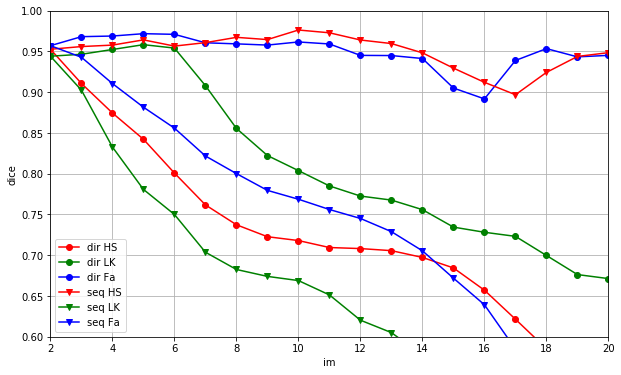

In [45]:
plt.figure(figsize=(10, 6))
x = range(im_begin+1,im_end+1)
plt.plot(x,dir_dices_HS, marker='o', color='r')
plt.plot(x,dir_dices_LK, marker='o', color='g')
plt.plot(x,dir_dices_FA, marker='o', color='b')
plt.plot(x,seq_dices_HS, marker='v', color='r')
plt.plot(x,seq_dices_LK, marker='v', color='g')
plt.plot(x,seq_dices_FA, marker='v', color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0.6,1))
plt.ylabel('dice')
plt.xlabel("im")
plt.grid()
plt.legend(['dir HS', 'dir LK', 'dir Fa', 'seq HS', 'seq LK', 'seq Fa'])
plt.show()

**Answer**: We can say that we have two optimal estimators: the Fa direct and the HS sequential. Depending on the estimator, we can have different performance of sequential and direct integrations.